| Variable | Definition                                 | Key                                                                                                                                                                                                |
|----------|--------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                                                                                                                                                                    |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd  pclass : A proxy for socio-economic status (SES)  1st = Upper  2nd = Middle  3rd = Lower                                                                                |
| sex      | Sex                                        |                                                                                                                                                                                                    |
| Age      | Age in years                               | Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5                                                                                                               |
| sibsp    | # of siblings / spouses aboard the Titanic | The dataset defines family relations in this way...  Sibling = brother, sister, stepbrother, stepsister  Spouse = husband, wife (mistresses and fiancés were ignored)                              |
| parch    | # of parents / children aboard the Titanic | The dataset defines family relations in this way...  Parent = mother, father  Child = daughter, son, stepdaughter, stepson  Some children travelled only with a nanny, therefore parch=0 for them. |
| ticket   | Ticket number                              |                                                                                                                                                                                                    |
| fare     | Passenger fare                             |                                                                                                                                                                                                    |
| cabin    | Cabin number                               |                                                                                                                                                                                                    |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton                                                                                                                                                     |

In [1]:
import pandas as pd
import numpy as np
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
df_test = pd.read_csv('./data/test.csv')
df_train = pd.read_csv('./data/train.csv')

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


I want to extract the titles of the passengers on the ship. To do this I created a simple regex function that got all the values between ', and '.' This should have created a column that contains all the titles from the name category.

In [11]:
import re
str_srch = r',\s(.*?)\.' #get all values between ', ' and '.' 

In [12]:
df_train['title'] = [re.findall(str_srch,i) for i in df_train.Name.values]
df_train.title = [df_train.title.values[i][0] for i in range(df_train.shape[0])] 

In [13]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [14]:
#df_train.title.values #got 'em all

In [15]:
df_test['title'] = [re.findall(str_srch,i) for i in df_test.Name.values]
df_test.title = [df_test.title.values[i][0] for i in range(df_test.shape[0])] 

In [16]:
#df_test.title.values #here too

Time to look at missing values

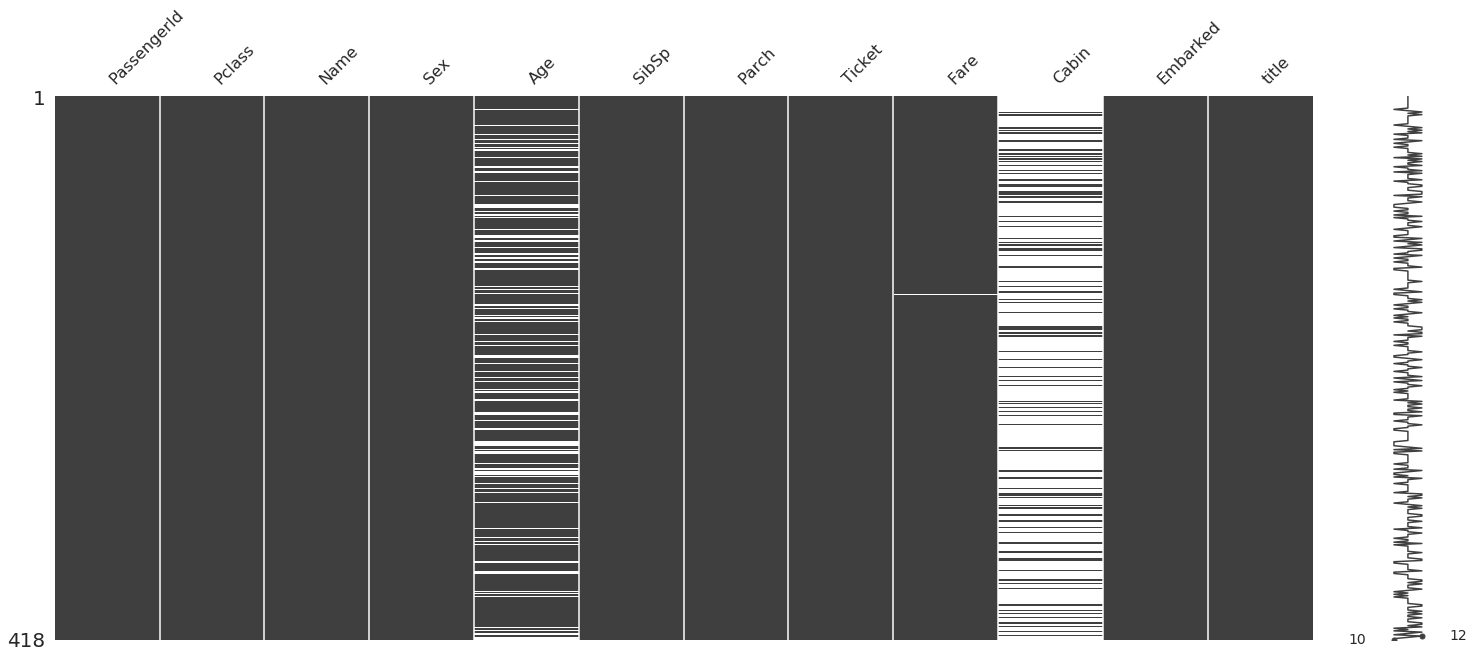

In [19]:
msno.matrix(df_test)

This is a problem. We have missing values in Fare, Age and Cabin and we will have to deal with all of them. We will look at Fare first since there is only one value. 

In [23]:
df_test[df_test.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr


Mr. Thomas Storey. A third class passenger who embarked from Southampton. 
We have his age but not his cabin. Given that this is the only passenger that we do not have a value for Fare I can be sure that this is MCAR (Missing Completely at Random) data. To fill this I'm going to be using deductive imputation and get the average value of a ticket for third class and replace the NaN value.

In [26]:
df_merge=pd.concat([df_train,df_test],sort=False)
df_merge.shape

(1309, 13)

Plugging in what we know about Mr. Storey we get a value of 9.77 for his ticket. 

In [33]:
df_merge[(df_merge.Pclass==3)&(df_merge.Embarked=='S')&(df_merge.Sex=='male')&(df_merge.SibSp==0&(df_merge.Parch==0))].Fare.mean()

9.767447552447553

In [36]:
df_test.Fare.fillna(9.77, inplace=True) # place the value

The problem with the Cabin column is the opposite. Only 19% of the data is valid in the test dataframe and 23% is valid in the train dataframe. The solution here is to drop the entire column.

In [21]:
df_test.drop('Cabin', axis=1, inplace=True)
df_train.drop('Cabin', axis=1, inplace=True)

The age column is the most interesting. The test data and train sets both have about 80% of the data intact. This is enough to attempt to make valid guesses with the data to attempt to fill in the missing values. 

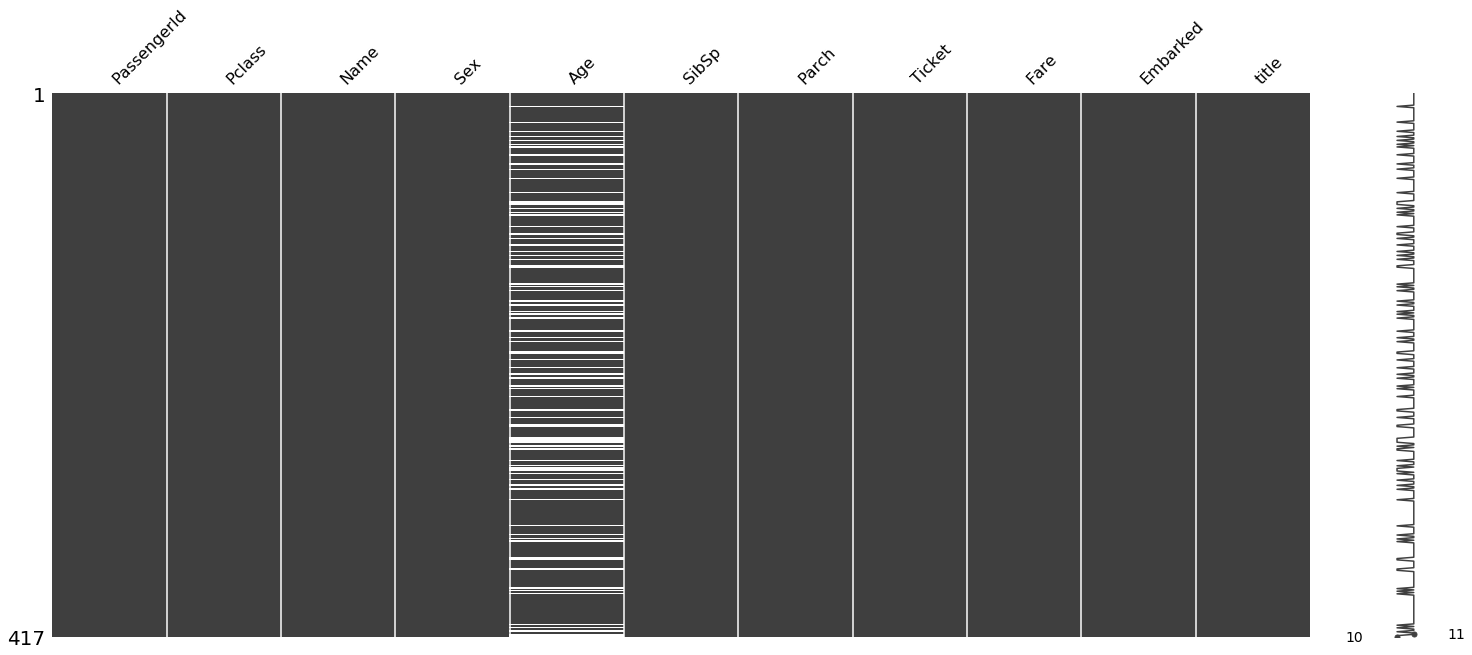

In [22]:
msno.matrix(df_test);

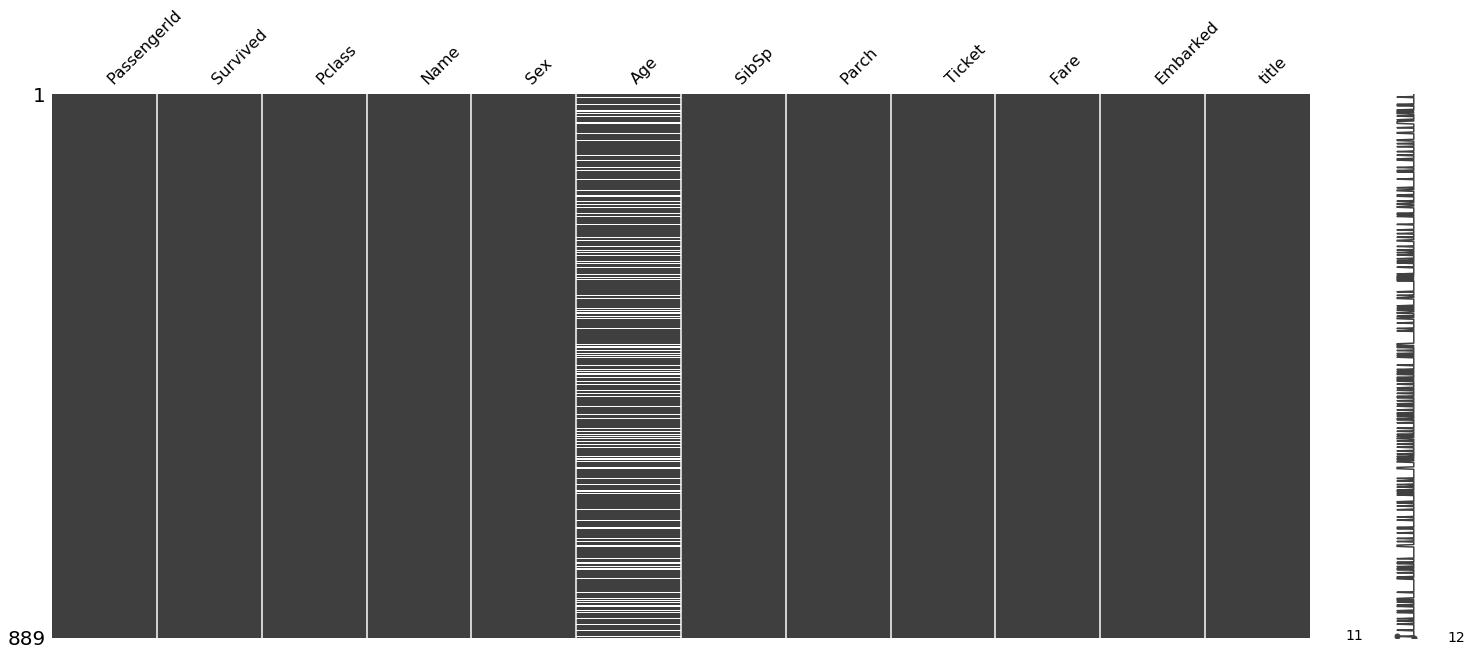

In [23]:
msno.matrix(df_train);

Looking at the mean values in both the test and train sets we see that the age values are almost identical coming in at about 30 years.

In [24]:
print(df_test.Age.mean())
print(df_train.Age.mean())

30.181268882175228
29.64209269662921


This does not appear when we seperate the data based on the passanger class. In both the test and train sets the mean age is abou 25 for trird class, 29 for second class and about 40 for third class.

In [25]:
print(df_test[df_test.Pclass==3].Age.mean())
print(df_test[df_test.Pclass==2].Age.mean())
print(df_test[df_test.Pclass==1].Age.mean())

23.776413793103448
28.7775
40.91836734693877


In [26]:
print(df_train[df_train.Pclass==3].Age.mean())
print(df_train[df_train.Pclass==2].Age.mean())
print(df_train[df_train.Pclass==1].Age.mean())

25.14061971830986
29.87763005780347
38.10554347826087


Looking at the mean age based on title we see that the test and train sets also show a string corrilation with people with the title of Master averaging under 10, people with the title of Miss appearing at about 21, people with the title of Ms and Mr appearing at about 32 and 37 respectively. 

In [27]:
print(df_test[df_test.title=='Master'].Age.mean())
print(df_test[df_test.title=='Mr'].Age.mean())
print(df_test[df_test.title=='Mrs'].Age.mean())
print(df_test[df_test.title=='Miss'].Age.mean())

7.406470588235294
31.843406593406595
38.903225806451616
21.774843750000002


In [28]:
print(df_train[df_train.title=='Master'].Age.mean())
print(df_train[df_train.title=='Mr'].Age.mean())
print(df_train[df_train.title=='Mrs'].Age.mean())
print(df_train[df_train.title=='Miss'].Age.mean())

4.574166666666667
32.368090452261306
35.654205607476634
21.662068965517243


The average age for location of people based on when they embarked is slightly higher from Cherbourg. I'm not sure it's signifigant for the model.

In [29]:
print(df_test[df_test.Embarked=='Q'].Age.mean())
print(df_test[df_test.Embarked=='C'].Age.mean())
print(df_test[df_test.Embarked=='S'].Age.mean())

29.318181818181817
34.73780487804878
28.61894273127753


I assume that the missing data is MCAR. I'm sure that there is no possibility that the missing data is not NMAR. There is no reason that the data would be purposefully hidden from us so the options are MCAR, where the data is missing simply because it was lost to time or the disaster, or MAR, the data is missing but it may be missing more from certain groups.

To check the type of missing data we will see if the variables we have are randomly distributed evenly between a dataset that has all values for age missing and a dataset that has all values filled. If both sets are approximately equal then we have MCAR. If not then we have MAR and must use imputation.

Let's create a new column to see if we have an age value and then run the data through seaborn to look at our data.

In [30]:
df_train.Age.fillna(0,inplace=True)
df_test.Age.fillna(0,inplace=True)
df_train['known_age']= np.where(df_train.Age==0,False,True)
df_test['known_age']= np.where(df_test.Age==0,False,True)

Merging the data togther. This is kept in a seperate dataframe to avoid conaminating the models.

In [31]:
df_graph = pd.concat([df_train,df_test], sort = False)
df_graph.shape

(1306, 13)

In [32]:
df_graph.drop('Survived',axis =1,inplace=True)

In [33]:
#df = df.drop(df[(df.score < 50) & (df.score > 20)].index)

#df_graph.drop(df_graph[~(df_graph.title=='Mr')|~(df_graph.title=='Miss')|~(df_graph.title=='Mrs')|~(df_graph.title=='Master')].index)

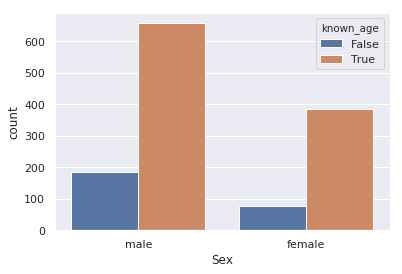

In [34]:
sns.set(style="darkgrid")
ax =sns.countplot(x = 'Sex', hue = 'known_age',data = df_graph, orient='v')
#ax =sns.countplot(x = 'Embarked', hue = 'known_age',data = df_graph, orient='v')

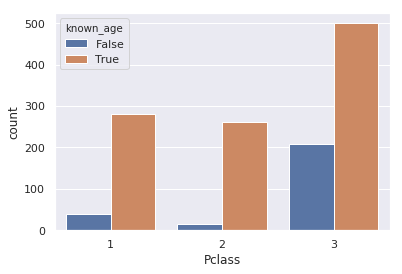

In [35]:
sns.set(style="darkgrid")
ax =sns.countplot(x = 'Pclass', hue = 'known_age',data = df_graph, orient='v')

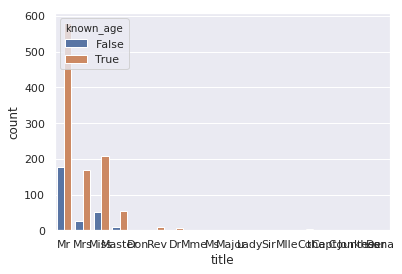

In [36]:
sns.set(style="darkgrid")
ax =sns.countplot(x = 'title', hue = 'known_age',data = df_graph, orient='v')

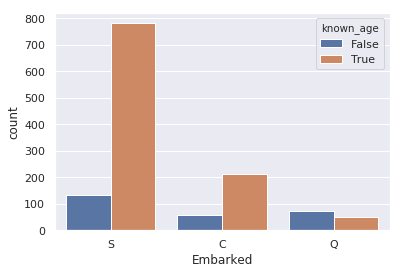

In [37]:
sns.set(style="darkgrid")
ax =sns.countplot(x = 'Embarked', hue = 'known_age',data = df_graph, orient='v')

Based on the above graphs the missing data does not appear to be completely random. In fact it appears to be strongly correlated with the values in Pclass, specifically with third class passengers. Given that the highest mortality rate was also in this group there is almost certainly a correlation that survival also factored into our knowledge of age.

I am going to create a model with Random Forest and dropping the age column. This will give us a baseline to work from. All models will have random state set to 42 to ensure that all models preform evenly. 

In [38]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,title,known_age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,True


In [39]:
df_model=df_train.copy()

In [40]:
def make_model_df(drop_names=[]):
    df_model=df_train.copy()
    df_model.drop(drop_names,axis=1,inplace=True)
    df_model=pd.get_dummies(df_model, columns=df_model.select_dtypes('object').columns.values)
    return df_model
    

In [41]:
df_model = make_model_df(['Name','Ticket','Age','known_age'])

In [42]:
df_model.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
0,1,0,3,1,0,7.2500,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,1,1,1,0,71.2833,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,3,1,3,0,0,7.9250,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,4,1,1,1,0,53.1000,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,0,3,0,0,8.0500,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [43]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop("Survived",1),df_model.Survived, random_state = 42)

In [44]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [45]:
rfc = RandomForestClassifier()

model=rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
pred_rfc_train = rfc.predict(X_train)
model.score(X_test,y_test)

0.7623318385650224

In [46]:
data = confusion_matrix(y_test,pred_rfc)

In [47]:
tn, fp, fn, tp = a=data.ravel()

In [48]:
print(tn, fp, fn, tp)

116 25 28 54


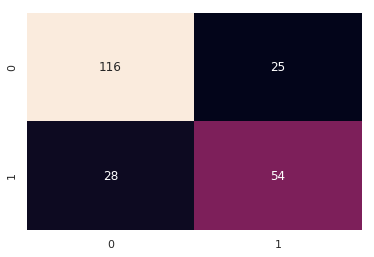

In [49]:
sns.set(style="darkgrid")
sns.heatmap(data,annot = True, fmt='g', cbar=False)

This is our base with Mean Accuracy Score of .78, 25 false positives and 24 false negatives. 

The next step is to do a very simple form of impudence and applying the mean value to missing data.

In [50]:
df_model = make_model_df(['Name','Ticket','known_age'])

In [51]:
df_model.Age.where(df_model.Age>0,np.NaN,inplace=True) 

In [52]:
df_model.Age.head(7)

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
5     NaN
6    54.0
Name: Age, dtype: float64

In [53]:
from fancyimpute import SimpleFill

/home/steven/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [54]:
fill = SimpleFill('mean',min_value=df_model.Age.min(),max_value=df_model.Age.max())

In [55]:
filled = fill.fit_transform(df_model)

In [56]:
df_model = pd.DataFrame(filled, columns=df_model.columns.values)

In [57]:
df_model.head(7)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,...,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
0,1.0,0.0,3.0,22.000000,1.0,0.0,7.2500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,38.000000,1.0,0.0,71.2833,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,1.0,3.0,26.000000,0.0,0.0,7.9250,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,1.0,1.0,35.000000,1.0,0.0,53.1000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.0,0.0,3.0,35.000000,0.0,0.0,8.0500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,6.0,0.0,3.0,29.642093,0.0,0.0,8.4583,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,7.0,0.0,1.0,54.000000,0.0,0.0,51.8625,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [58]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop("Survived",1),df_model.Survived, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rfc = RandomForestClassifier()

model=rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
pred_rfc_train = rfc.predict(X_train)
model.score(X_test,y_test)

0.7892376681614349

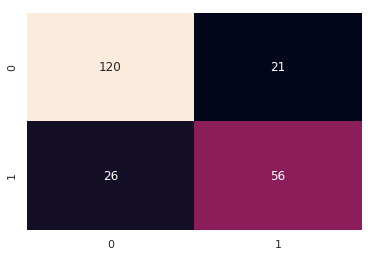

In [59]:
sns.set(style="darkgrid")
data = confusion_matrix(y_test,pred_rfc)
sns.heatmap(data,annot = True, fmt='g', cbar=False)

In [60]:
df_model = make_model_df(['Name','Ticket','known_age'])
df_model.Age.where(df_model.Age>0,np.NaN,inplace=True) 

In [61]:
from fancyimpute import IterativeImputer

In [62]:
def impute_data(df):
    fill = IterativeImputer(min_value=df.Age.min(),
                            max_value=df.Age.max(), 
                            sample_posterior=True,
                            random_state=42)
    filled = fill.fit_transform(df)
    df = pd.DataFrame(filled, columns=df.columns.values)
    #df_model.head(7)
    return df

In [63]:
df_0 = impute_data(df_model)
df_1 = impute_data(df_model)
df_2 = impute_data(df_model)
df_3 = impute_data(df_model)
df_4 = impute_data(df_model)
df_5 = impute_data(df_model)
df_6 = impute_data(df_model)
df_7 = impute_data(df_model)
df_8 = impute_data(df_model)
df_9 = impute_data(df_model)

In [64]:
def s_scale(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop("Survived",1),
                                                        df.Survived, 
                                                        random_state = 42)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, y_train, y_test

In [65]:
pred_rfc = []

In [66]:
X_train, X_test, y_train, y_test = s_scale(df_0)
rfc0 = RandomForestClassifier()
model0=rfc0.fit(X_train,y_train)
pred_rfc.append(rfc0.predict(X_test))
model0.score(X_test,y_test)

0.8071748878923767

In [67]:
X_train, X_test, y_train, y_test = s_scale(df_1)
rfc1 = RandomForestClassifier()
model1=rfc1.fit(X_train,y_train)
pred_rfc.append(rfc1.predict(X_test))
model1.score(X_test,y_test)

0.7937219730941704

In [68]:
X_train, X_test, y_train, y_test = s_scale(df_2)
rfc2 = RandomForestClassifier()
model2=rfc2.fit(X_train,y_train)
pred_rfc.append(rfc2.predict(X_test))
model2.score(X_test,y_test)

0.7847533632286996

In [69]:
X_train, X_test, y_train, y_test = s_scale(df_3)
rfc3 = RandomForestClassifier()
model3=rfc3.fit(X_train,y_train)
pred_rfc.append(rfc3.predict(X_test))
model3.score(X_test,y_test)

0.7892376681614349

In [70]:
X_train, X_test, y_train, y_test = s_scale(df_4)
rfc4 = RandomForestClassifier()
model4=rfc4.fit(X_train,y_train)
pred_rfc.append(rfc4.predict(X_test))
model4.score(X_test,y_test)

0.8071748878923767

In [71]:
X_train, X_test, y_train, y_test = s_scale(df_5)
rfc5 = RandomForestClassifier()
model5=rfc5.fit(X_train,y_train)
pred_rfc.append(rfc5.predict(X_test))
model5.score(X_test,y_test)

0.7802690582959642

In [72]:
X_train, X_test, y_train, y_test = s_scale(df_6)
rfc6 = RandomForestClassifier()
model6=rfc6.fit(X_train,y_train)
pred_rfc.append(rfc6.predict(X_test))
model6.score(X_test,y_test)

0.7982062780269058

In [73]:
X_train, X_test, y_train, y_test = s_scale(df_7)
rfc7 = RandomForestClassifier()
model7=rfc7.fit(X_train,y_train)
pred_rfc.append(rfc7.predict(X_test))
model7.score(X_test,y_test)

0.7937219730941704

In [74]:
X_train, X_test, y_train, y_test = s_scale(df_8)
rfc8 = RandomForestClassifier()
model8=rfc8.fit(X_train,y_train)
pred_rfc.append(rfc8.predict(X_test))
model8.score(X_test,y_test)

0.8026905829596412

In [75]:
X_train, X_test, y_train, y_test = s_scale(df_9)
rfc9 = RandomForestClassifier()
model9=rfc9.fit(X_train,y_train)
pred_rfc.append(rfc9.predict(X_test))
model9.score(X_test,y_test)

0.8161434977578476

In [79]:
pred_rfc

[array([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
        1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        1., 

In [183]:
np.random.randint(0,2)

1

In [190]:
preds=[]
for i in range(len(pred_rfc[0])):
    #print(i)
    new_pred=0
    for j in range(len(pred_rfc)):
        new_pred +=pred_rfc[j][i]
    if new_pred>5:
        preds.append(1)
    elif new_pred<5:
        preds.append(0)
    else:
        preds.append(np.random.randint(0,2))
preds = np.array(preds)

In [191]:
preds

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1])

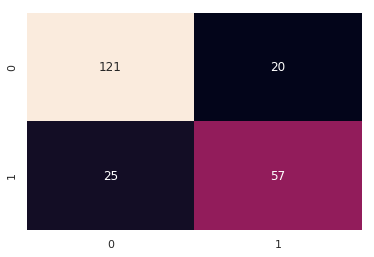

In [192]:
sns.set(style="darkgrid")
data = confusion_matrix(y_test,preds)
sns.heatmap(data,annot = True, fmt='g', cbar=False)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop("Survived",1),df_model.Survived, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rfc = RandomForestClassifier()

model=rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
pred_rfc_train = rfc.predict(X_train)
model.score(X_test,y_test)

0.7892376681614349

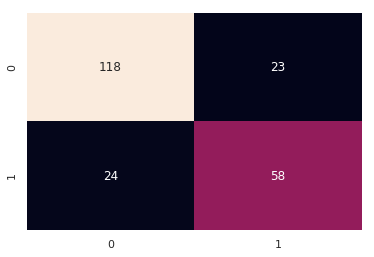

In [205]:
sns.set(style="darkgrid")
data = confusion_matrix(y_test,pred_rfc)
sns.heatmap(data,annot = True, fmt='g', cbar=False)

In [206]:
df_model = make_model_df(['Name','Ticket','known_age'])
df_model.Age.where(df_model.Age>0,np.NaN,inplace=True) 

In [207]:
from fancyimpute import SoftImpute

In [208]:
fill = SoftImpute()
filled = fill.fit_transform(df_model)
df_model = pd.DataFrame(filled, columns=df_model.columns.values)
df_model.head(7)

[SoftImpute] Max Singular Value of X_init = 15381.554173
[SoftImpute] Iter 1: observed MAE=0.913454 rank=3
[SoftImpute] Iter 2: observed MAE=0.926779 rank=3
[SoftImpute] Iter 3: observed MAE=0.932875 rank=3
[SoftImpute] Iter 4: observed MAE=0.935271 rank=3
[SoftImpute] Iter 5: observed MAE=0.936062 rank=3
[SoftImpute] Iter 6: observed MAE=0.936320 rank=3
[SoftImpute] Iter 7: observed MAE=0.936405 rank=3
[SoftImpute] Iter 8: observed MAE=0.936436 rank=3
[SoftImpute] Iter 9: observed MAE=0.936449 rank=3
[SoftImpute] Iter 10: observed MAE=0.936455 rank=3
[SoftImpute] Iter 11: observed MAE=0.936458 rank=3
[SoftImpute] Stopped after iteration 11 for lambda=307.631083


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,...,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
0,1.0,0.0,3.0,22.000000,1.0,0.0,7.2500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,38.000000,1.0,0.0,71.2833,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,1.0,3.0,26.000000,0.0,0.0,7.9250,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,1.0,1.0,35.000000,1.0,0.0,53.1000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.0,0.0,3.0,35.000000,0.0,0.0,8.0500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,6.0,0.0,3.0,0.986068,0.0,0.0,8.4583,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,7.0,0.0,1.0,54.000000,0.0,0.0,51.8625,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [209]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop("Survived",1),df_model.Survived, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rfc = RandomForestClassifier()

model=rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
pred_rfc_train = rfc.predict(X_train)
model.score(X_test,y_test)

0.7757847533632287

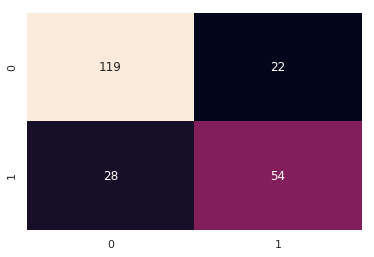

In [210]:
sns.set(style="darkgrid")
data = confusion_matrix(y_test,pred_rfc)
sns.heatmap(data,annot = True, fmt='g', cbar=False)

In [211]:
df_model = make_model_df(['Name','Ticket','known_age'])
df_model.Age.where(df_model.Age>0,np.NaN,inplace=True) 

In [212]:
from fancyimpute import SimilarityWeightedAveraging

In [213]:
fill = SimilarityWeightedAveraging()
filled = fill.fit_transform(df_model)
df_model = pd.DataFrame(filled, columns=df_model.columns.values)
df_model.head(7)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,...,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
0,1.0,0.0,3.0,22.000000,1.0,0.0,7.2500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,38.000000,1.0,0.0,71.2833,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,1.0,3.0,26.000000,0.0,0.0,7.9250,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,1.0,1.0,35.000000,1.0,0.0,53.1000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.0,0.0,3.0,35.000000,0.0,0.0,8.0500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,6.0,0.0,3.0,27.083962,0.0,0.0,8.4583,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,7.0,0.0,1.0,54.000000,0.0,0.0,51.8625,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [214]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop("Survived",1),df_model.Survived, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rfc = RandomForestClassifier()

model=rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
pred_rfc_train = rfc.predict(X_train)
model.score(X_test,y_test)

0.7668161434977578

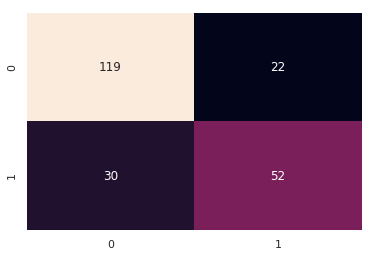

In [215]:
sns.set(style="darkgrid")
data = confusion_matrix(y_test,pred_rfc)
sns.heatmap(data,annot = True, fmt='g', cbar=False)

In [120]:
df_model = make_model_df(['Name','Ticket','known_age'])
df_model.Age.where(df_model.Age>0,np.NaN,inplace=True) 

In [121]:
from fancyimpute import IterativeSVD

In [122]:
fill = IterativeSVD()
filled = fill.fit_transform(df_model)
df_model = pd.DataFrame(filled, columns=df_model.columns.values)
df_model.head(7)

[IterativeSVD] Iter 1: observed MAE=1.701285
[IterativeSVD] Iter 2: observed MAE=0.695652
[IterativeSVD] Iter 3: observed MAE=0.166814


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,...,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
0,1.0,0.0,3.0,22.000000,1.0,0.0,7.2500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,38.000000,1.0,0.0,71.2833,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,1.0,3.0,26.000000,0.0,0.0,7.9250,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,1.0,1.0,35.000000,1.0,0.0,53.1000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.0,0.0,3.0,35.000000,0.0,0.0,8.0500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,6.0,0.0,3.0,1.200248,0.0,0.0,8.4583,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,7.0,0.0,1.0,54.000000,0.0,0.0,51.8625,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [123]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop("Survived",1),df_model.Survived, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rfc = RandomForestClassifier()

model=rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
pred_rfc_train = rfc.predict(X_train)
model.score(X_test,y_test)

0.7802690582959642

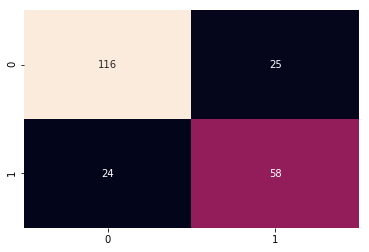

In [124]:
sns.set(style="darkgrid")
data = confusion_matrix(y_test,pred_rfc)
sns.heatmap(data,annot = True, fmt='g', cbar=False)

In [125]:
df_model = make_model_df(['Name','Ticket','known_age'])
df_model.Age.where(df_model.Age>0,np.NaN,inplace=True) 

In [126]:
from fancyimpute import KNN

In [127]:
fill = KNN()
filled = fill.fit_transform(df_model)
df_model = pd.DataFrame(filled, columns=df_model.columns.values)
df_model.head(7)

Imputing row 1/889 with 0 missing, elapsed time: 0.162
Imputing row 101/889 with 1 missing, elapsed time: 0.163
Imputing row 201/889 with 1 missing, elapsed time: 0.164
Imputing row 301/889 with 1 missing, elapsed time: 0.164
Imputing row 401/889 with 0 missing, elapsed time: 0.165
Imputing row 501/889 with 0 missing, elapsed time: 0.166
Imputing row 601/889 with 1 missing, elapsed time: 0.167
Imputing row 701/889 with 0 missing, elapsed time: 0.167
Imputing row 801/889 with 0 missing, elapsed time: 0.168


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,...,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
0,1.0,0.0,3.0,22.000000,1.0,0.0,7.2500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,38.000000,1.0,0.0,71.2833,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,1.0,3.0,26.000000,0.0,0.0,7.9250,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,1.0,1.0,35.000000,1.0,0.0,53.1000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.0,0.0,3.0,35.000000,0.0,0.0,8.0500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,6.0,0.0,3.0,31.616715,0.0,0.0,8.4583,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,7.0,0.0,1.0,54.000000,0.0,0.0,51.8625,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [128]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop("Survived",1),df_model.Survived, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rfc = RandomForestClassifier()

model=rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
pred_rfc_train = rfc.predict(X_train)
model.score(X_test,y_test)

0.7847533632286996

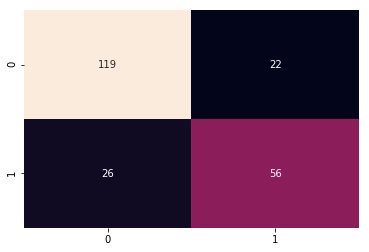

In [129]:
sns.set(style="darkgrid")
data = confusion_matrix(y_test,pred_rfc)
sns.heatmap(data,annot = True, fmt='g', cbar=False)

In [130]:
df_model = make_model_df(['Name','Ticket','known_age'])
df_model.Age.where(df_model.Age>0,np.NaN,inplace=True)

In [131]:
from fancyimpute import MatrixFactorization

In [132]:
fill = MatrixFactorization()
filled = fill.fit_transform(df_model)
df_model = pd.DataFrame(filled, columns=df_model.columns.values)
df_model.head(7)

Train on 23043 samples, validate on 2561 samples
Epoch 1/10000
23043/23043 [==============================] - 0s 16us/step - loss: 1.1661 - val_loss: 0.7050
Epoch 2/10000
23043/23043 [==============================] - 0s 0us/step - loss: 1.1641 - val_loss: 0.7045
Epoch 3/10000
23043/23043 [==============================] - 0s 0us/step - loss: 1.1626 - val_loss: 0.7040
Epoch 4/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.1612 - val_loss: 0.7035
Epoch 5/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.1598 - val_loss: 0.7031
Epoch 6/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.1584 - val_loss: 0.7026
Epoch 7/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.1570 - val_loss: 0.7020
Epoch 8/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.1554 - val_loss: 0.7015
Epoch 9/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.1538 - val_

Epoch 77/10000
23043/23043 [==============================] - 0s 0us/step - loss: 1.0615 - val_loss: 0.6708
Epoch 78/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.0603 - val_loss: 0.6703
Epoch 79/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.0592 - val_loss: 0.6700
Epoch 80/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.0580 - val_loss: 0.6695
Epoch 81/10000
23043/23043 [==============================] - 0s 0us/step - loss: 1.0569 - val_loss: 0.6691
Epoch 82/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.0557 - val_loss: 0.6687
Epoch 83/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.0546 - val_loss: 0.6683
Epoch 84/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.0534 - val_loss: 0.6678
Epoch 85/10000
23043/23043 [==============================] - 0s 1us/step - loss: 1.0523 - val_loss: 0.6674
Epoch 86/10000
23043/23043 [

Epoch 153/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.9724 - val_loss: 0.6317
Epoch 154/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.9712 - val_loss: 0.6310
Epoch 155/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.9700 - val_loss: 0.6304
Epoch 156/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.9687 - val_loss: 0.6298
Epoch 157/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.9675 - val_loss: 0.6292
Epoch 158/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.9663 - val_loss: 0.6285
Epoch 159/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.9650 - val_loss: 0.6280
Epoch 160/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.9638 - val_loss: 0.6273
Epoch 161/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.9626 - val_loss: 0.6267
Epoch 162/10000
230

Epoch 229/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.8808 - val_loss: 0.5877
Epoch 230/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.8797 - val_loss: 0.5872
Epoch 231/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.8786 - val_loss: 0.5867
Epoch 232/10000
23043/23043 [==============================] - 0s 0us/step - loss: 0.8774 - val_loss: 0.5862
Epoch 233/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.8763 - val_loss: 0.5858
Epoch 234/10000
23043/23043 [==============================] - 0s 0us/step - loss: 0.8752 - val_loss: 0.5852
Epoch 235/10000
23043/23043 [==============================] - 0s 0us/step - loss: 0.8741 - val_loss: 0.5848
Epoch 236/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.8729 - val_loss: 0.5843
Epoch 237/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.8718 - val_loss: 0.5839
Epoch 238/10000
230

Epoch 305/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.8009 - val_loss: 0.5583
Epoch 306/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.7999 - val_loss: 0.5580
Epoch 307/10000
23043/23043 [==============================] - 0s 0us/step - loss: 0.7990 - val_loss: 0.5577
Epoch 308/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.7980 - val_loss: 0.5574
Epoch 309/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.7970 - val_loss: 0.5572
Epoch 310/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.7961 - val_loss: 0.5568
Epoch 311/10000
23043/23043 [==============================] - 0s 0us/step - loss: 0.7951 - val_loss: 0.5566
Epoch 312/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.7941 - val_loss: 0.5563
Epoch 313/10000
23043/23043 [==============================] - 0s 1us/step - loss: 0.7932 - val_loss: 0.5560
Epoch 314/10000
230

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,...,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
0,1.0,0.0,3.0,22.000000,1.0,0.0,7.2500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,38.000000,1.0,0.0,71.2833,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,1.0,3.0,26.000000,0.0,0.0,7.9250,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,1.0,1.0,35.000000,1.0,0.0,53.1000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.0,0.0,3.0,35.000000,0.0,0.0,8.0500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,6.0,0.0,3.0,24.326767,0.0,0.0,8.4583,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,7.0,0.0,1.0,54.000000,0.0,0.0,51.8625,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [133]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop("Survived",1),df_model.Survived, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rfc = RandomForestClassifier()

model=rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
pred_rfc_train = rfc.predict(X_train)
model.score(X_test,y_test)

0.7847533632286996

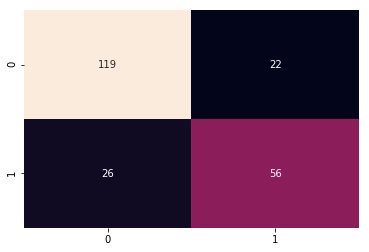

In [134]:
sns.set(style="darkgrid")
data = confusion_matrix(y_test,pred_rfc)
sns.heatmap(data,annot = True, fmt='g', cbar=False)

In [135]:
df_model = make_model_df(['Name','Ticket','known_age'])
df_model.Age.where(df_model.Age>0,np.NaN,inplace=True)

In [136]:
from fancyimpute import NuclearNormMinimization

In [137]:
fill = NuclearNormMinimization()
filled = fill.fit_transform(df_model)
df_model = pd.DataFrame(filled, columns=df_model.columns.values)
df_model.head(7)

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 601934
eps = 1.00e-05, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 473383, constraints m = 524945
Cones:	primal zero / dual free vars: 25781
	linear vars: 77343
	sd vars: 421821, sd blks: 1
Setup time: 2.62e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.90e+21  6.75e+21  1.00e+00 -2.06e+27  2.18e+26  8.93e+26  5.89e-01 
   100| 3.81e-03  3.13e-03  1.79e-03  1.76e+04  1.75e+04  1.91e-11  6.17e+01 
   200| 6.86e-04  6.27e-04  4.17e-04  1.77e

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,...,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
0,1.0,0.0,3.0,22.000000,1.0,0.0,7.2500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,38.000000,1.0,0.0,71.2833,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.0,1.0,3.0,26.000000,0.0,0.0,7.9250,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,1.0,1.0,35.000000,1.0,0.0,53.1000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.0,0.0,3.0,35.000000,0.0,0.0,8.0500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,6.0,0.0,3.0,2.629538,0.0,0.0,8.4583,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,7.0,0.0,1.0,54.000000,0.0,0.0,51.8625,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [138]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop("Survived",1),df_model.Survived, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rfc = RandomForestClassifier()

model=rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
pred_rfc_train = rfc.predict(X_train)
model.score(X_test,y_test)

0.7892376681614349

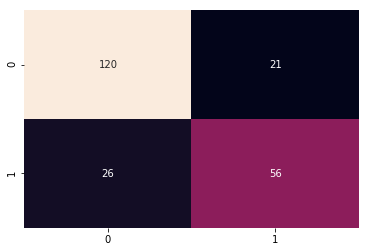

In [139]:
sns.set(style="darkgrid")
data = confusion_matrix(y_test,pred_rfc)
sns.heatmap(data,annot = True, fmt='g', cbar=False)